# Healthcare Analytics

**Core Business Problem:**<br>
How can hospital management improve on their resource allocation and functioning based on severity of patient and improve the existing functionality  
Looking at the past severity of patients medical condition how can hospital be prepared to handle emergency cases.<br>
The length of stay (LOS) is an important indicator of the efficiency of hospital management. Reduction in the number of inpatient days results in decreased risk of infection and medication side effects, improvement in the quality of treatment, and increased hospital profit with more efficient bed management. 

**Stakeholders:** <br>
Hospital administrator<br>

**Data Science Problem:**<br> Predict how long patient is going to stay in hospital as per severity of illness

**Pain point :**<br> Allocation of resources at unknown emergency 
--If patient is going to stay in hospital for longer time than expected then hospital management might not be able to accomodate other critical patient


**Evaluation Metric** <br>

The evaluation metric for this task will be `accuracy_score`. Read up about it more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode (connected = True)

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import textwrap

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load dataset
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


# Basic Data check

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [5]:
train_data.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [6]:
train_data.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


# Severity of illness

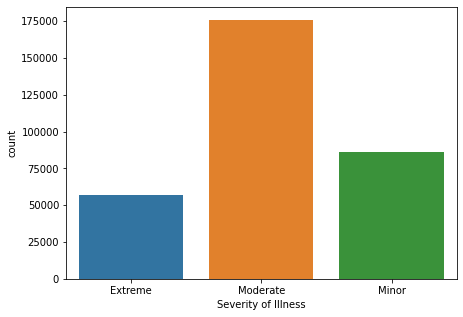

In [7]:
plt.figure(figsize=(7,5))
sns.countplot(x='Severity of Illness',data=train_data)
plt.show()

## Type of admission & severity of illness

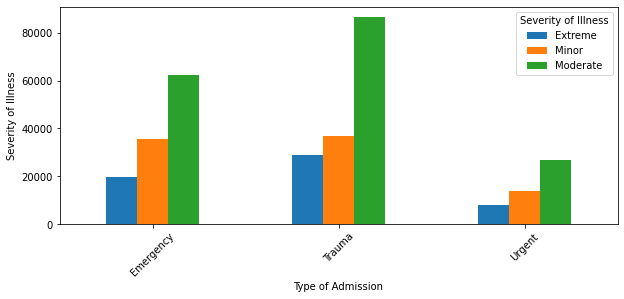

In [8]:
train_data.groupby("Type of Admission")['Severity of Illness'].value_counts().unstack().plot.bar(figsize=(10,4))
plt.ylabel("Severity of Illness")
plt.xticks(rotation=45);

## Types of hospital code

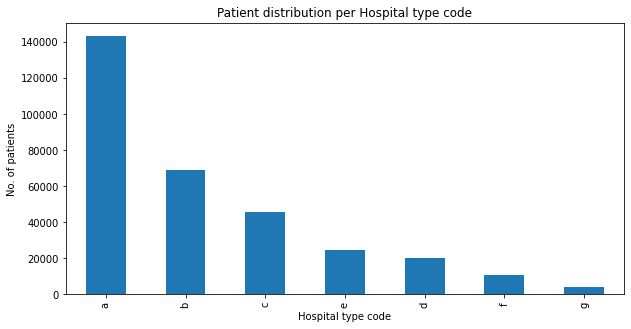

In [9]:
df_hosp_code = train_data['Hospital_type_code'].value_counts()

df_hosp_code.plot(kind = 'bar', 
                  xlabel = 'Hospital type code', ylabel = 'No. of patients',
                 title = 'Patient distribution per Hospital type code',
                 figsize =(10,5))
plt.xticks(rotation = 90)
plt.show()

**Insights :**<br>
As we can see, the hospital type `A` has a much higher patient case load when in comparison any of the other hospital codes. Hospital type `G` has the least case load. Hence, hospital type A has a much higher likelihood of running out of patient beds while G has the least.

## Hospital region code

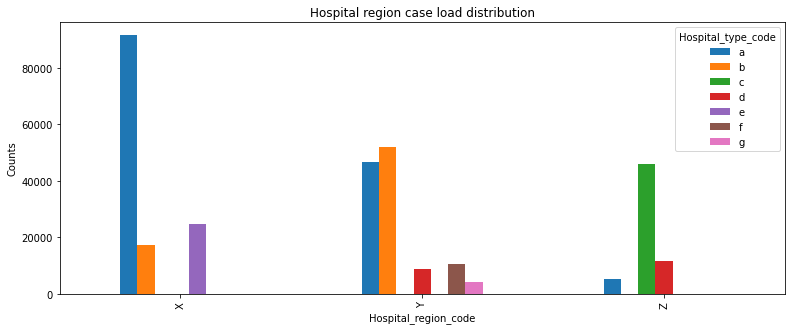

In [10]:
train_data.groupby('Hospital_region_code')['Hospital_type_code'].value_counts()\
.unstack().plot(kind = 'bar', figsize = (13,5),
                ylabel = 'Counts',
                title = 'Hospital region case load distribution' )
plt.show()

**Insights :**<br>


As we can see from the above plot, the case loads in hospital region `X` is marginally higher than hospital region `Y` and the least in region Z . For region `X`, the hospital type `a` had highest case load while it was more equally balanced between `a` and `b` in region `Y`. For region `Z`, highest case loads were in hospital type `c`. Hospitals in region `X` seem to show better distribution amogst all the hospital types.

For region `Y`, distribution between `a` and `b` is ideal but `f`,`d` and `g` have been under utilised. For `Z`, cases in hospital `c` were easily the highest but `a` and `d` are extremely under utilised.

# Length of Stay

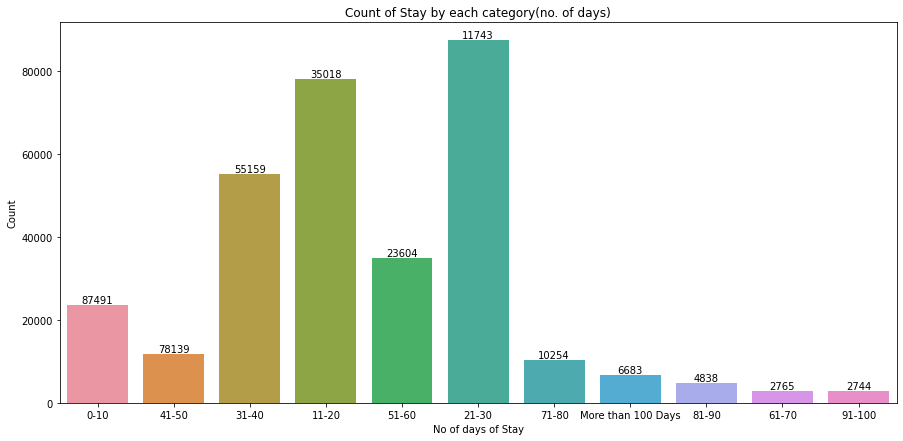

In [11]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x='Stay',data=train_data)
plt.xlabel("No of days of Stay")
plt.ylabel("Count")
plt.title("Count of Stay by each category(no. of days)")

#adding the text labels
rects = ax.patches
labels = train_data['Stay'].value_counts().tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

c_labels = train_data['Stay'].value_counts().index.tolist()
c_name=[textwrap.fill(text,10) for text in c_labels]

### Type of admission vs LOS

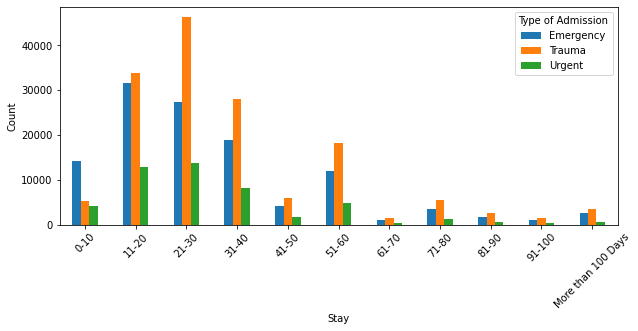

In [12]:
# Let's check the cross tab of the Dependent variable with the Admission_Type variable
train_data.groupby("Stay")['Type of Admission'].value_counts().unstack().plot.bar(figsize=(10,4))
plt.ylabel("Count")
plt.xticks(rotation=45);

**Insights:**<br>
Trauma cases have more number of admissions compare to others. LOS of trauma cases is comparably more with other significant

## Severity of Illness vs LOS

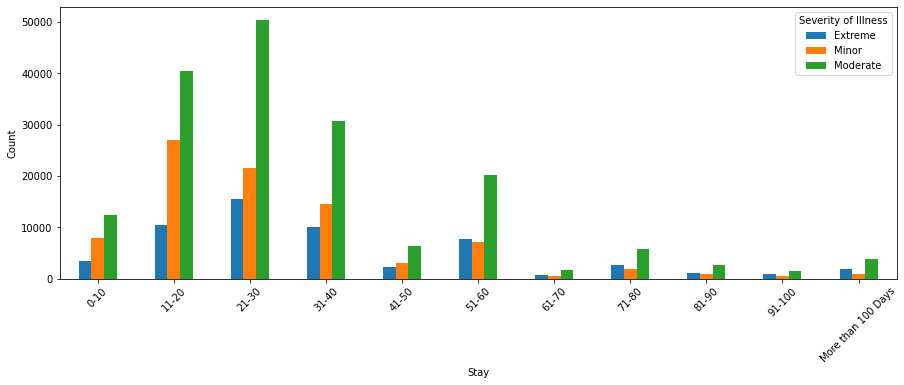

In [13]:
train_data.groupby("Stay")['Severity of Illness'].value_counts().unstack().plot.bar(figsize=(15,5))
plt.ylabel("Count")
plt.xticks(rotation=45);

## Age Vs Severity of Illness

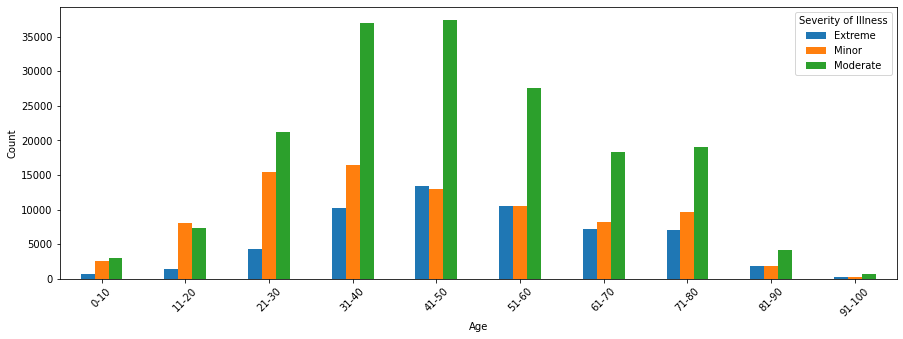

In [14]:
train_data.groupby("Age")['Severity of Illness'].value_counts().unstack().plot.bar(figsize=(15,5))
plt.ylabel("Count")
plt.xticks(rotation=45);

**Insights :**<br>
Extreme cases are least for each age group. However, the extreme cases in relation to the moderate and minor cases seem to increase with higher age groups.

## Extra rooms in hospital

<AxesSubplot:ylabel='Hospital_code'>

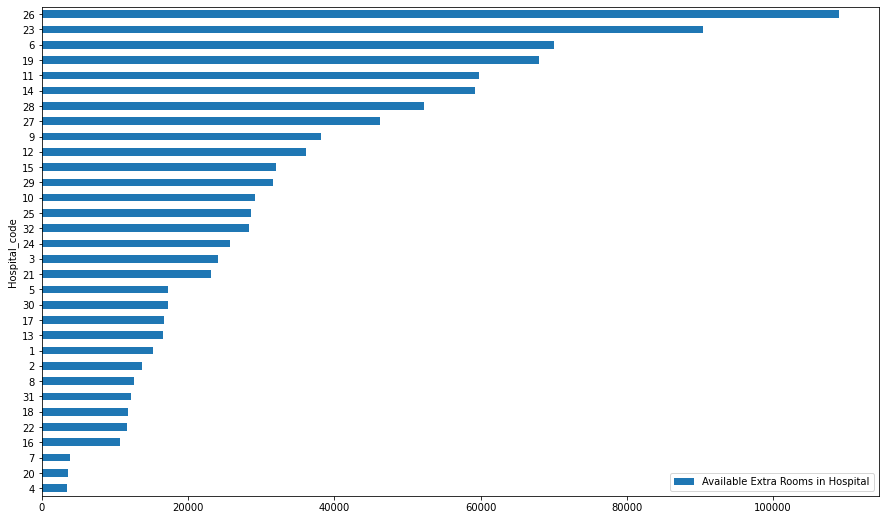

In [15]:

train_data[['Hospital_code','Available Extra Rooms in Hospital']].groupby('Hospital_code').sum().\
sort_values(by='Available Extra Rooms in Hospital',ascending=True).plot(kind = 'barh', figsize=(15,9))


### **Insights -**

Hospitals code 26,23,6,19 have the max number of available rooms

## Available rooms Vs Region code

In [16]:
df_beds=train_data[['Hospital_code','Available Extra Rooms in Hospital','Hospital_region_code']]
df_beds['Hospital_region_code']=df_beds['Hospital_region_code'].map({'X':1,'Y':2,'Z':3})
df_beds_grouped= df_beds.groupby('Hospital_code')[['Available Extra Rooms in Hospital','Hospital_region_code']].median().reset_index()

In [17]:
df_beds_grouped['Hospital_region_code']=df_beds_grouped['Hospital_region_code'].map({1:'X',2:'Y',3:'Z'})
df_beds_grouped.head()

,Hospital_code,Available Extra Rooms in Hospital,Hospital_region_code
0,1,3,Y
1,2,2,Z
2,3,3,Z
3,4,3,X
4,5,3,X


In [18]:
df_beds_1=df_beds_grouped.groupby('Hospital_region_code')['Available Extra Rooms in Hospital'].sum().reset_index()
fig4=px.pie(df_beds_1,values='Available Extra Rooms in Hospital',names='Hospital_region_code',hole=0.4)
fig4.update_layout(title='Number of extra rooms in each region code',title_x=0.5)
fig4.update_traces(textinfo='percent+label')

**Insights :**<br>
From the above pie chart, we see that the number of extra available rooms are almost equally distributed amongst the three region codes. This is an ideal scenario.

# Department

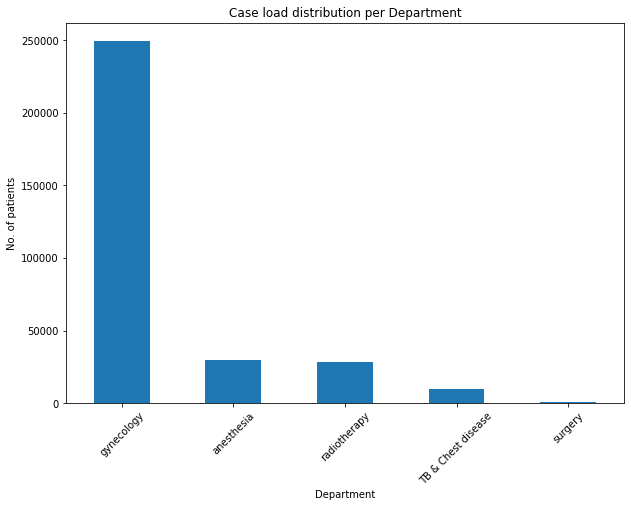

In [19]:
df_depart = train_data['Department'].value_counts()

df_depart.plot(kind = 'bar', 
                  xlabel = 'Department', ylabel = 'No. of patients',
                 title = 'Case load distribution per Department',
                 figsize =(10,7))
plt.xticks(rotation = 45)
plt.show()

## No of cases as per departments of hospital handled by different types of hospital


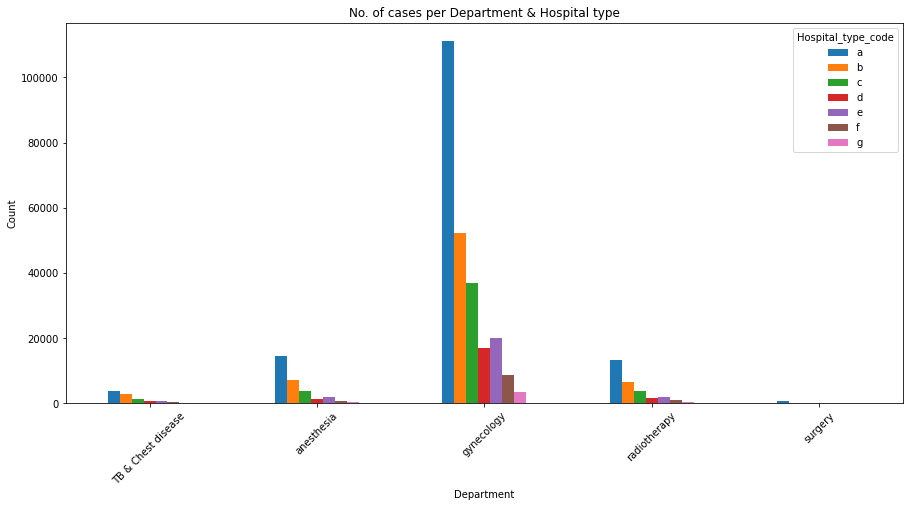

In [20]:
train_data.groupby("Department")['Hospital_type_code'].value_counts().unstack().plot.bar(figsize=(15,7))
plt.title('No. of cases per Department & Hospital type')
plt.ylabel("Count")
plt.xticks(rotation=45);

### **Insights**
Patient have prefered Type A hospital more compared to other types of hospital. 
Gynecology needs to considered important as patient inflow is more.

### **Suggestion**-
More beds need to be allocated for gynec department. Medicine & surgical equipments inventory needs to adjusted considering more patients of gynec.

**Hospital type :**<br>
**Type A** - These hospitals provide comprehensive secondary and tertiary health care services and are referral centers for hospitals both in the public and private health systems.<br>
**Type B** - These hospitals provide primary and secondary care services.<br>
**Type C** - Type C hospitals provide primary care services and basic secondary care services.

## Department vs LOS

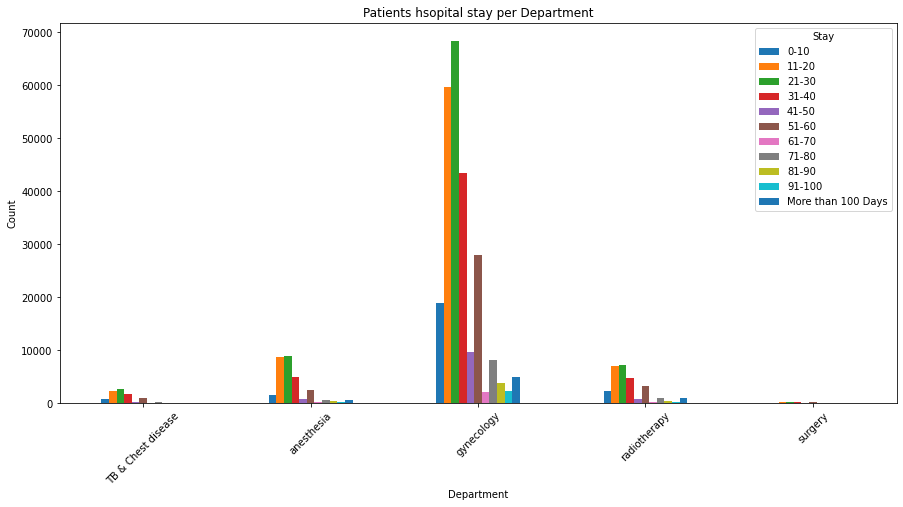

In [21]:
train_data.groupby("Department")['Stay'].value_counts().unstack().plot.bar(figsize=(15,7))
plt.title('Patients hsopital stay per Department')
plt.ylabel("Count")
plt.xticks(rotation=45);

### Insights -

Gynecology have more patients with majority LOS

# Data Wrangling

In [22]:
le = LabelEncoder()
train_data['Stay'] = le.fit_transform(train_data['Stay'])
train_data['Age'] = le.fit_transform(train_data['Age'])

In [23]:
need_to_encode = ['Hospital_type_code', 'Hospital_region_code','Ward_Facility_Code', 'Ward_Type']
for column in need_to_encode:
    le = LabelEncoder()
    le.fit(train_data[column])
    train_data[column] = le.transform(train_data[column])

In [24]:
# Dummies for Department column
df_dept=pd.get_dummies(train_data['Department'])
train_data=pd.merge(train_data, df_dept, on=train_data.index)
train_data.drop('key_0',axis=1,inplace=True)

# Dummies for Type of Admission column
df_adm = pd.get_dummies(train_data['Type of Admission'])
train_data = pd.merge(train_data, df_adm, on=train_data.index)
train_data.drop('key_0', axis=1, inplace=True)

#Dummies for Severity of Illness column
df_sev_ill = pd.get_dummies(train_data['Severity of Illness'])
train_data = pd.merge(train_data, df_sev_ill, on=train_data.index)
train_data.drop('key_0', axis=1, inplace=True)

In [25]:
target = train_data['Stay']
train = train_data.fillna(0)
# test = test.fillna(0)
train = train.drop(['patientid', 'Stay','Department', 'Type of Admission', 'Severity of Illness'], axis=1)
# test = test.drop(['patientid', 'dataset'], axis=1)
train.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient',
       'Visitors with Patient', 'Age', 'Admission_Deposit',
       'TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
       'surgery', 'Emergency', 'Trauma', 'Urgent', 'Extreme', 'Minor',
       'Moderate'],
      dtype='object')

In [26]:
categorical = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code',
               'TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy','surgery','Ward_Type', 
               'Ward_Facility_Code', 'City_Code_Patient', 'Emergency', 'Trauma', 'Urgent', 
               'Extreme', 'Minor','Moderate']

In [27]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(train, target, random_state=0, test_size=0.2, shuffle=True)
y=y.astype('int')
y_val=y_val.astype('int')

# Machine Learning

## LGBM Classifier

In [28]:
model = LGBMClassifier(random_state=666)
model.fit(X, y, categorical_feature=categorical)
preds = model.predict(X_val)
print('LGBM accuracy: ', accuracy_score(y_val, preds)*100, '%')



LGBM accuracy:  42.81654314784575 %


## Random Forest Classifier

In [29]:
rf_clf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 100,\
                                n_jobs = 100, random_state = 63)

#Fitting the model
rf_clf.fit(X, y)
y_pred_rf = rf_clf.predict(X_val)

#Scoring the model for train data and test data

rf_score1 = accuracy_score(y_val, y_pred_rf)


print("Train Score is: %.2f " %rf_score1)    



Train Score is: 0.41 


## Optuna Optimization<br>
Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values

In [30]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=0)
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                           max_depth=max_depth, num_leaves=num_leaves, min_child_samples=min_child_samples,
                           random_state=0)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X, y)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

def optimize():
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=20)
    return study.best_params

params = optimize()

[I 2021-01-20 22:18:15,388] A new study created in memory with name: no-name-e2e69573-e890-467c-b31c-13906071c6f3
[I 2021-01-20 22:19:07,426] Trial 0 finished with value: 0.22335447808064313 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7151893948534829, 'num_leaves': 4933, 'min_child_samples': 198}. Best is trial 0 with value: 0.22335447808064313.
[I 2021-01-20 22:19:14,379] Trial 1 finished with value: 0.39982414269564126 and parameters: {'max_depth': 9, 'n_estimators': 10, 'learning_rate': 0.6235637344296027, 'num_leaves': 3470, 'min_child_samples': 61}. Best is trial 1 with value: 0.39982414269564126.
[I 2021-01-20 22:20:55,146] Trial 2 finished with value: 0.15632458233890215 and parameters: {'max_depth': 3, 'n_estimators': 487, 'learning_rate': 0.8121687475586203, 'num_leaves': 2224, 'min_child_samples': 91}. Best is trial 1 with value: 0.39982414269564126.
[I 2021-01-20 22:22:12,495] Trial 3 finished with value: 0.19353724406481598 and parameters: {'ma

In [31]:
params['random_state'] = 666
model = LGBMClassifier(**params)
model.fit(X, y, categorical_feature=categorical)
preds = model.predict(X_val)
print('LGBM accuracy: ', accuracy_score(y_val, preds)*100, '%')


LGBM accuracy:  43.025373696771766 %
